In [1]:
%matplotlib inline
%load_ext autoreload

In [2]:
from matplotlib import pyplot
from cartopy import crs
import xarray
import numpy

In [141]:
grid_file = '/global/homes/b/bhillma/codes/tempestremap/ne4.g'
ds = xarray.open_dataset(grid_file)

In [127]:
def plot_exodus(ds, ax=None, do_line_collection=True, **plot_kwargs):
    import numpy
    from matplotlib import pyplot
    from cartopy import crs, feature
    from matplotlib import collections

    # set up the axes and map
    if ax is None: 
        ax = pyplot.subplot(projection=crs.PlateCarree())
        ax.set_global()

        # add ocean and land fills
        ax.add_feature(feature.OCEAN, zorder=0)
        ax.add_feature(feature.LAND, zorder=0)

    # cartesian coordinates
    x = ds['coord'][0,:].squeeze()
    y = ds['coord'][1,:].squeeze()
    z = ds['coord'][2,:].squeeze()

    # convert to longitude and latitude
    lon = numpy.arctan2(y, x) * 180.0 / numpy.pi
    lat = numpy.arcsin(z) * 180.0 / numpy.pi

    # corner indices
    corner_indices = ds['connect1']

    # Plot black lines by default
    if 'color' not in plot_kwargs.keys():
        plot_kwargs['color'] = 'black'

    # Plot either as a line collection or directly using 2d arrays
    if do_line_collection:
        xx = lon[corner_indices[:,:] - 1]
        yy = lat[corner_indices[:,:] - 1]
        lines = [[[xx[i,j], yy[i,j]] for j in range(xx.shape[1])] for i in range(xx.shape[0])]
        line_collection = collections.LineCollection(lines, transform=crs.Geodetic(), **plot_kwargs)
        pl = ax.add_collection(line_collection)
    else:
        xx = lon[corner_indices[:,:] - 1].transpose()
        yy = lat[corner_indices[:,:] - 1].transpose()
        pl = ax.plot(xx, yy, transform=crs.Geodetic(), **plot_kwargs)
    
    return pl, ax

In [128]:
%%timeit
figure, ax = pyplot.subplots(1,1, subplot_kw=dict(projection=crs.PlateCarree()))
pl = plot_exodus(ds)
pyplot.close()

1min 37s ± 4.03 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [129]:
%%timeit
figure, ax = pyplot.subplots(1,1, subplot_kw=dict(projection=crs.PlateCarree()))
pl = plot_exodus(ds, do_line_collection=False)
pyplot.close()

2min 3s ± 5.08 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [169]:
def plot_exodus(ds, ax=None, do_line_collection=True, **plot_kwargs):
    import numpy
    from matplotlib import pyplot
    from cartopy import crs, feature
    from matplotlib import collections
    from time import perf_counter

    # set up the axes and map
    if ax is None: 
        ax = pyplot.subplot(projection=crs.PlateCarree())
        ax.set_global()

        # add ocean and land fills
        ax.add_feature(feature.OCEAN, zorder=0)
        ax.add_feature(feature.LAND, zorder=0)

    # cartesian coordinates
    x = ds['coord'][0,:].squeeze()
    y = ds['coord'][1,:].squeeze()
    z = ds['coord'][2,:].squeeze()

    # convert to longitude and latitude
    lon = numpy.arctan2(y, x) * 180.0 / numpy.pi
    lat = numpy.arcsin(z) * 180.0 / numpy.pi

    # corner indices
    corner_indices = ds['connect1']

    # Plot black lines by default
    if 'color' not in plot_kwargs.keys():
        plot_kwargs['color'] = 'black'

    # Plot either as a line collection or directly using 2d arrays
    if do_line_collection:
        
        xx = lon[corner_indices[:,:] - 1]
        yy = lat[corner_indices[:,:] - 1]
        t1 = perf_counter()
        lines = [[
            ax.projection.transform_point(xx[i,j], yy[i,j], crs.Geodetic()) for j in range(xx.shape[1])
        ] for i in range(xx.shape[0])]
        
        t2 = perf_counter()
        print('projection: ', t2 - t1)
        t1 = perf_counter()
        #lines = [[[XYZ[i,j,0], XYZ[i,j,1]] for j in range(xx.shape[1])] for i in range(xx.shape[0])]
        line_collection = collections.LineCollection(lines, **plot_kwargs)
        t2 = perf_counter()
        print('line collections: ', t2 - t1)
        t1 = perf_counter()
        pl = ax.add_collection(line_collection)
        t2 = perf_counter()
        print('ax.add_collection(): ', t2 - t1)
    else:
        xx = lon[corner_indices[:,:] - 1].transpose()
        yy = lat[corner_indices[:,:] - 1].transpose()
        pl = ax.plot(xx, yy, transform=crs.Geodetic(), **plot_kwargs)
    
    return pl, ax

projection:  0.09403431508690119
line collections:  0.001259627053514123
ax.add_collection():  0.0008725130464881659


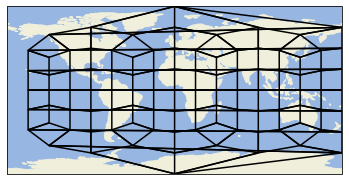

In [170]:
#%%timeit
figure, ax = pyplot.subplots(1,1, subplot_kw=dict(projection=crs.PlateCarree()))
pl = plot_exodus(ds)
#pyplot.close()

In [ ]:
# explicitly transform points
xx, yy = ax.projection.transform_points(crs.Geodetic(), xx, yy)